# Create json file of PTC counts for lineChart

ref: https://geoffboeing.com/2015/10/exporting-python-data-geojson/  
Huom: `with open(output_filename, 'wb') as output_file:` should be `'w'` not `'wb'`  

**Resources**  
geoJSON minifier: https://jsonformatter.org/json-minify  

In [1]:
import sys
sys.executable

'/home/test/anaconda3/envs/vfh/bin/python'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

from IPython.display import HTML, display
import datetime
import matplotlib.dates as mdates
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

from datetime import datetime

import json

# Functions

In [3]:
# https://geoffboeing.com/2015/10/exporting-python-data-geojson/
def df_to_geojson(df, properties, lat="latitude", lon="longitude"):
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"Point",
                               "coordinates":[]}}
        feature["geometry"]["coordinates"] = [row[lon],row[lat]]
        for prop in properties:
            feature["properties"][prop] = int(row[prop])
        geojson["features"].append(feature)
    return geojson

# Variables

In [4]:
ward=10

# Read PUDO data from csv file
Created by the following query:  
```
CREATE TABLE cnangini.trip_data_092018_counts AS
SELECT 
	TO_CHAR(pickup_datetime, 'FMDay') pickup_dow,
	TO_CHAR(pickup_datetime, 'HH24') pickup_hr,
	TO_CHAR(dropoff_datetime, 'FMDay') dropoff_dow,
	TO_CHAR(dropoff_datetime, 'HH24') dropoff_hr,
	pickup_ward2018, dropoff_ward2018, 
	pickup_neighbourhood, dropoff_neighbourhood
FROM ptc.trip_data_new_geom a
WHERE pickup_mun_id = 69 AND dropoff_mun_id = 69
AND pickup_datetime > '20180901' AND pickup_datetime < '20181001'
```

In [5]:
fname = '../../../Documents/PROJECTS/VFH/COT_PAGE/INTERIM_DATA/FROM_PGADMIN/tripdata_092018_forCounts.csv'

df = pd.read_csv(fname)

print(df.shape)
df.head(5)

(4164492, 8)


,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood
0,Saturday,11,Saturday,11,12.0,10.0,104.0,76.0
1,Saturday,12,Saturday,12,10.0,13.0,78.0,75.0
2,Saturday,22,Saturday,22,10.0,11.0,76.0,76.0
3,Sunday,15,Sunday,15,13.0,11.0,77.0,76.0
4,Saturday,1,Saturday,1,11.0,5.0,95.0,111.0


In [6]:
hours = df['pickup_hr'].sort_values().unique()
hours

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [7]:
print(df.loc[(df['pickup_dow']=='Monday') & 
            (df['pickup_hr']==0) &
            (df['pickup_ward2018']==10),'pickup_hr'].count())
df.loc[(df['pickup_dow']=='Monday') & (df['pickup_hr']==0) & (df['pickup_ward2018']==10)]

4146


,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood
41748,Monday,0,Monday,0,10.0,18.0,82.0,37.0
41982,Monday,0,Monday,0,10.0,14.0,77.0,68.0
42032,Monday,0,Monday,0,10.0,13.0,77.0,75.0
42071,Monday,0,Monday,0,10.0,10.0,77.0,77.0
42076,Monday,0,Monday,0,10.0,11.0,77.0,80.0
42140,Monday,0,Monday,0,10.0,9.0,77.0,93.0
42145,Monday,0,Monday,0,10.0,19.0,76.0,59.0
42200,Monday,0,Monday,0,10.0,11.0,77.0,95.0
42203,Monday,0,Monday,0,10.0,11.0,77.0,80.0
42263,Monday,0,Monday,0,10.0,4.0,76.0,85.0


# Process data

## 1. Filter out rows where neither pickup or dropoff wards are the ward of interest
Make col `keep` = 1 for where pick-up or for drop-off wards are the ward of interest

In [8]:
# Assign a Pickup or Dropoff in column 'type'
df['keep'] = np.nan

df.loc[(df['pickup_ward2018']==ward) | (df['dropoff_ward2018']==ward), 'keep'] = 1

In [9]:
# Keep only rows where `keep` is not null
df = df[df['keep'].notnull()]

In [10]:
df.head(5)

,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood,keep
0,Saturday,11,Saturday,11,12.0,10.0,104.0,76.0,1.0
1,Saturday,12,Saturday,12,10.0,13.0,78.0,75.0,1.0
2,Saturday,22,Saturday,22,10.0,11.0,76.0,76.0,1.0
10,Saturday,1,Saturday,1,10.0,13.0,78.0,74.0,1.0
11,Saturday,1,Saturday,1,10.0,11.0,77.0,78.0,1.0


In [11]:
print(df.loc[(df['pickup_dow']=='Monday') & 
            (df['pickup_hr']==0) &
            (df['pickup_ward2018']==10),'pickup_hr'].count())
df.loc[(df['pickup_dow']=='Monday') & (df['pickup_hr']==0) & (df['pickup_ward2018']==10)]

4146


,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood,keep
41748,Monday,0,Monday,0,10.0,18.0,82.0,37.0,1.0
41982,Monday,0,Monday,0,10.0,14.0,77.0,68.0,1.0
42032,Monday,0,Monday,0,10.0,13.0,77.0,75.0,1.0
42071,Monday,0,Monday,0,10.0,10.0,77.0,77.0,1.0
42076,Monday,0,Monday,0,10.0,11.0,77.0,80.0,1.0
42140,Monday,0,Monday,0,10.0,9.0,77.0,93.0,1.0
42145,Monday,0,Monday,0,10.0,19.0,76.0,59.0,1.0
42200,Monday,0,Monday,0,10.0,11.0,77.0,95.0,1.0
42203,Monday,0,Monday,0,10.0,11.0,77.0,80.0,1.0
42263,Monday,0,Monday,0,10.0,4.0,76.0,85.0,1.0


## 2. Mark if row is a pickup or a dropoff
pickup is where pickup ward == ward, dropoff is where dropoff_ward == ward  
Note that a row can contain **both** a pickup and a dropoff !!! 

groupby ref: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/  

In [12]:
df['pu'] = np.nan
df['do'] = np.nan

In [13]:
df.loc[df['pickup_ward2018']==ward, 'pu'] = 1

In [14]:
df.loc[df['dropoff_ward2018']==ward, 'do'] = 1

In [15]:
df.head(5)

,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood,keep,pu,do
0,Saturday,11,Saturday,11,12.0,10.0,104.0,76.0,1.0,NaN,1.0
1,Saturday,12,Saturday,12,10.0,13.0,78.0,75.0,1.0,1.0,NaN
2,Saturday,22,Saturday,22,10.0,11.0,76.0,76.0,1.0,1.0,NaN
10,Saturday,1,Saturday,1,10.0,13.0,78.0,74.0,1.0,1.0,NaN
11,Saturday,1,Saturday,1,10.0,11.0,77.0,78.0,1.0,1.0,NaN


In [16]:
print(df.loc[(df['pickup_dow']=='Monday') & 
            (df['pickup_hr']==0) &
            (df['pickup_ward2018']==10),'pickup_hr'].count())
df.loc[(df['pickup_dow']=='Monday') & (df['pickup_hr']==0) & (df['pickup_ward2018']==10)].head(11)

4146


,pickup_dow,pickup_hr,dropoff_dow,dropoff_hr,pickup_ward2018,dropoff_ward2018,pickup_neighbourhood,dropoff_neighbourhood,keep,pu,do
41748,Monday,0,Monday,0,10.0,18.0,82.0,37.0,1.0,1.0,NaN
41982,Monday,0,Monday,0,10.0,14.0,77.0,68.0,1.0,1.0,NaN
42032,Monday,0,Monday,0,10.0,13.0,77.0,75.0,1.0,1.0,NaN
42071,Monday,0,Monday,0,10.0,10.0,77.0,77.0,1.0,1.0,1.0
42076,Monday,0,Monday,0,10.0,11.0,77.0,80.0,1.0,1.0,NaN
42140,Monday,0,Monday,0,10.0,9.0,77.0,93.0,1.0,1.0,NaN
42145,Monday,0,Monday,0,10.0,19.0,76.0,59.0,1.0,1.0,NaN
42200,Monday,0,Monday,0,10.0,11.0,77.0,95.0,1.0,1.0,NaN
42203,Monday,0,Monday,0,10.0,11.0,77.0,80.0,1.0,1.0,NaN
42263,Monday,0,Monday,0,10.0,4.0,76.0,85.0,1.0,1.0,NaN


## 3. Aggregate pickups and dropoffs for this_tod
Sums counts for same hour of each same day.

In [17]:
list(df)

['pickup_dow',
 'pickup_hr',
 'dropoff_dow',
 'dropoff_hr',
 'pickup_ward2018',
 'dropoff_ward2018',
 'pickup_neighbourhood',
 'dropoff_neighbourhood',
 'keep',
 'pu',
 'do']

In [18]:
this_type='pickup'
df.loc[df['pickup_ward2018']==ward].groupby([this_type+'_dow', this_type +'_hr'], as_index=False).agg({this_type +"_ward2018": "count"})

,pickup_dow,pickup_hr,pickup_ward2018
0,Friday,0,5494
1,Friday,1,3959
2,Friday,2,2912
3,Friday,3,1322
4,Friday,4,706
5,Friday,5,706
6,Friday,6,1546
7,Friday,7,3432
8,Friday,8,5698
9,Friday,9,5722


In [19]:
this_type = 'pickup'
df_agg_pu = pd.DataFrame()
df_agg_pu = df.loc[df['pickup_ward2018']==ward].groupby([this_type+'_dow', this_type +'_hr'], as_index=False).agg({this_type +"_ward2018": "count"})
df_agg_pu =df_agg_pu.rename(columns={this_type +'_dow': 'dow', this_type+'_ward2018': 'pcounts'})

In [20]:
this_type = 'dropoff'
df_agg_do = pd.DataFrame()
df_agg_do = df.loc[df['dropoff_ward2018']==ward].groupby([this_type+'_dow', this_type +'_hr'], as_index=False).agg({this_type +"_ward2018": "count"})
df_agg_do =df_agg_do.rename(columns={this_type+'_dow': 'dow',this_type+'_ward2018': 'dcounts'})

In [21]:
print(df_agg_pu.shape)
print(list(df_agg_pu))

(168, 3)
['dow', 'pickup_hr', 'pcounts']


In [22]:
df_agg_pu.head(25)

,dow,pickup_hr,pcounts
0,Friday,0,5494
1,Friday,1,3959
2,Friday,2,2912
3,Friday,3,1322
4,Friday,4,706
5,Friday,5,706
6,Friday,6,1546
7,Friday,7,3432
8,Friday,8,5698
9,Friday,9,5722


In [23]:
df_agg_do.head(25)

,dow,dropoff_hr,dcounts
0,Friday,0,3428
1,Friday,1,2004
2,Friday,2,1488
3,Friday,3,739
4,Friday,4,661
5,Friday,5,1371
6,Friday,6,2788
7,Friday,7,5019
8,Friday,8,7676
9,Friday,9,7921


In [24]:
df_agg_pu.loc[(df_agg_pu['dow']=='Monday') & 
            (df_agg_pu['pickup_hr']==0)]
# df.loc[(df['pickup_dow']=='Monday') & (df['pickup_hr']==0) & (df['pickup_ward2018']==10)]

,dow,pickup_hr,pcounts
24,Monday,0,4146


## 4. Join pickups on top of dropoffs

In [25]:
print(df_agg_pu.shape)
print(df_agg_do.shape)

df_merge=pd.DataFrame()

df_merge=pd.concat([df_agg_pu, df_agg_do[['dropoff_hr','dcounts']]], axis=1, sort=False)

df_merge

(168, 3)
(168, 3)


,dow,pickup_hr,pcounts,dropoff_hr,dcounts
0,Friday,0,5494,0,3428
1,Friday,1,3959,1,2004
2,Friday,2,2912,2,1488
3,Friday,3,1322,3,739
4,Friday,4,706,4,661
5,Friday,5,706,5,1371
6,Friday,6,1546,6,2788
7,Friday,7,3432,7,5019
8,Friday,8,5698,8,7676
9,Friday,9,5722,9,7921


## 5. Add column to store sum of pick-ups and drop-offs

In [26]:
df_merge['pudo'] = np.nan
df_merge['pudo'] = df_merge['pcounts'] + df_merge['dcounts']

In [27]:
df_merge.head(11)

,dow,pickup_hr,pcounts,dropoff_hr,dcounts,pudo
0,Friday,0,5494,0,3428,8922
1,Friday,1,3959,1,2004,5963
2,Friday,2,2912,2,1488,4400
3,Friday,3,1322,3,739,2061
4,Friday,4,706,4,661,1367
5,Friday,5,706,5,1371,2077
6,Friday,6,1546,6,2788,4334
7,Friday,7,3432,7,5019,8451
8,Friday,8,5698,8,7676,13374
9,Friday,9,5722,9,7921,13643


## 6. Look to see if pickup_hr = dropoff_hr
https://stackoverflow.com/questions/27474921/compare-two-columns-using-pandas

In [28]:
df_merge['same'] = np.where((df_merge['pickup_hr'] == df_merge['dropoff_hr']), df_merge['pickup_hr'], np.nan)

In [29]:
df_merge.head(25)

,dow,pickup_hr,pcounts,dropoff_hr,dcounts,pudo,same
0,Friday,0,5494,0,3428,8922,0.0
1,Friday,1,3959,1,2004,5963,1.0
2,Friday,2,2912,2,1488,4400,2.0
3,Friday,3,1322,3,739,2061,3.0
4,Friday,4,706,4,661,1367,4.0
5,Friday,5,706,5,1371,2077,5.0
6,Friday,6,1546,6,2788,4334,6.0
7,Friday,7,3432,7,5019,8451,7.0
8,Friday,8,5698,8,7676,13374,8.0
9,Friday,9,5722,9,7921,13643,9.0


In [30]:
# See if anything in 'same' in NaN
df_merge.loc[df_merge['same'].isnull()]

,dow,pickup_hr,pcounts,dropoff_hr,dcounts,pudo,same


In [31]:
# => pickup and dropoff hours are the same so can simply just have an 'hr' column
df_merge = df_merge.rename(columns={'pickup_hr': 'hr'})
df_merge.drop(['dropoff_hr', 'same'], axis=1)

,dow,hr,pcounts,dcounts,pudo
0,Friday,0,5494,3428,8922
1,Friday,1,3959,2004,5963
2,Friday,2,2912,1488,4400
3,Friday,3,1322,739,2061
4,Friday,4,706,661,1367
5,Friday,5,706,1371,2077
6,Friday,6,1546,2788,4334
7,Friday,7,3432,5019,8451
8,Friday,8,5698,7676,13374
9,Friday,9,5722,7921,13643


## 7. Reorder so that table starts on Monday at hour 0

In [32]:
# https://stackoverflow.com/questions/44991438/lambda-including-if-elif-else

df_merge['alphadow'] = np.nan

df_merge['alphadow'] = (
    np.where(
        df_merge['dow'] == 'Monday', 0, 
        np.where(
            df_merge['dow'] == 'Tuesday', 1,
            np.where(
                df_merge['dow'] == 'Wednesday', 2,
                np.where(
                    df_merge['dow'] == 'Thursday', 3,
                        np.where(
                        df_merge['dow'] == 'Friday', 4,
                            np.where(
                            df_merge['dow'] == 'Saturday', 5,   
                            6 # else
                        )
                    )
                )
            )
        )
    )
)

In [33]:
df_merge = df_merge.sort_values(['alphadow', 'hr'], ascending=[True, True])

df_merge = df_merge.reset_index()

df_merge.head(22)

,index,dow,hr,pcounts,dropoff_hr,dcounts,pudo,same,alphadow
0,24,Monday,0,4146,0,2877,7023,0.0,0
1,25,Monday,1,2804,1,1710,4514,1.0,0
2,26,Monday,2,2462,2,1430,3892,2.0,0
3,27,Monday,3,1283,3,834,2117,3.0,0
4,28,Monday,4,796,4,720,1516,4.0,0
5,29,Monday,5,729,5,1469,2198,5.0,0
6,30,Monday,6,1485,6,2556,4041,6.0,0
7,31,Monday,7,2784,7,3949,6733,7.0,0
8,32,Monday,8,4647,8,5897,10544,8.0,0
9,33,Monday,9,5136,9,6699,11835,9.0,0


# Check against database

## pick-ups in ward

**WARD 10 Monday, hr 0 in db**  

```
SELECT COUNT(*) FROM cnangini.trip_data_092018_counts
WHERE pickup_ward2018 = 10
AND pickup_dow = 'Monday'
AND pickup_hr = '00'
```
=> **4146 for ward 10**  
=> **265 for ward 1**  

In [34]:
print('ward: ' + repr(ward))
df_merge.loc[(df_merge['dow']=='Monday') & (df_merge['hr']==0), ['dow','hr','pcounts']]
# => CHECK OK

ward: 10


,dow,hr,pcounts
0,Monday,0,4146


**WARD 10 Wednesday, hr 17 in db**  

```
SELECT COUNT(*) FROM cnangini.trip_data_092018_counts
WHERE pickup_ward2018 = 10
AND pickup_dow = 'Wednesday'
AND pickup_hr = '17'
```
=> **5830 for ward 10**  
=> **834 for ward 1** 

In [35]:
print('ward: ' + repr(ward))
df_merge.loc[(df_merge['dow']=='Wednesday') & (df_merge['hr']==17), ['dow','hr','pcounts']]
# => CHECK OK

ward: 10


,dow,hr,pcounts
65,Wednesday,17,5830


**WARD 10 Saturday, hr 23 in db**  

```
SELECT COUNT(*) FROM cnangini.trip_data_092018_counts
WHERE pickup_ward2018 = 10
AND pickup_dow = 'Saturday'
AND pickup_hr = '23'
```
=> **17,374 for ward 10**  
=> **827 for ward 1** 

In [36]:
print('ward: ' + repr(ward))
df_merge.loc[(df_merge['dow']=='Saturday') & (df_merge['hr']==23), ['dow','hr','pcounts']]
# => CHECK OK

ward: 10


,dow,hr,pcounts
143,Saturday,23,17374


## drop-offs in ward

**WARD 10 Monday, hr 0 in db**  

```
SELECT COUNT(*) FROM cnangini.trip_data_092018_counts
WHERE dropoff_ward2018 = 10
AND dropoff_dow = 'Monday'
AND dropoff_hr = '00'
```
=> **2877 for ward 10**  
=> **313 for ward 1**  

In [37]:
print('ward: ' + repr(ward))
df_merge.loc[(df_merge['dow']=='Monday') & (df_merge['hr']==0), ['dow','hr','dcounts']]
# => CHECK OK

ward: 10


,dow,hr,dcounts
0,Monday,0,2877


**WARD 10 Monday, hr 0 in db**  

```
SELECT COUNT(*) FROM cnangini.trip_data_092018_counts
WHERE dropoff_ward2018 = 10
AND dropoff_dow = 'Saturday'
AND dropoff_hr = '23'
```
=> **15,792 for ward 10**  
=> **803 for ward 1**  

In [38]:
print('ward: ' + repr(ward))
df_merge.loc[(df_merge['dow']=='Saturday') & (df_merge['hr']==23), ['dow','hr','dcounts']]
# => CHECK OK

ward: 10


,dow,hr,dcounts
143,Saturday,23,15792


# Plot PTC counts

In [39]:
print(df_merge.shape)
print(df_merge['dcounts'].max())
print(df_merge['pcounts'].max())

(168, 9)
15792
17374


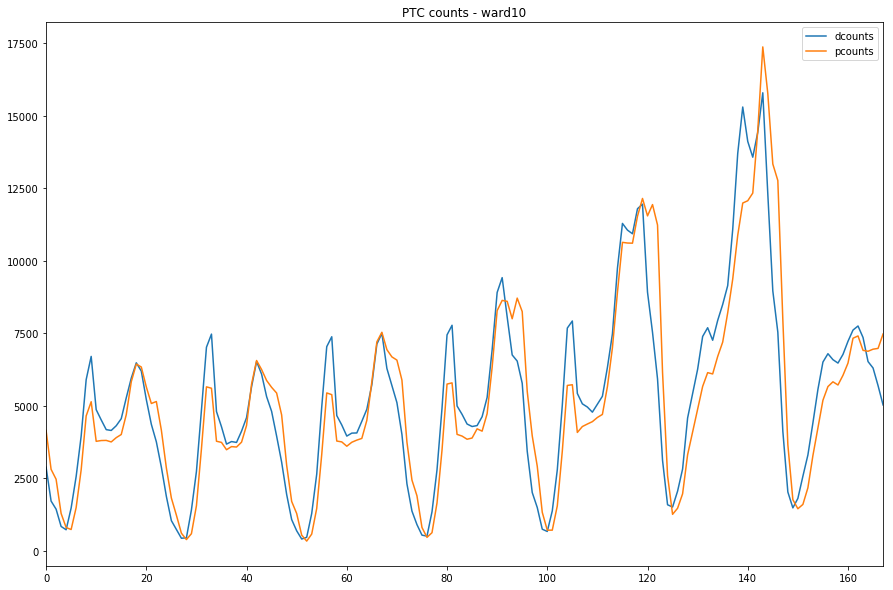

In [40]:
df_merge.plot(y=["dcounts", "pcounts"], kind="line", use_index=True,
             title='PTC counts - ward' + repr(ward),
             figsize=(15,10))

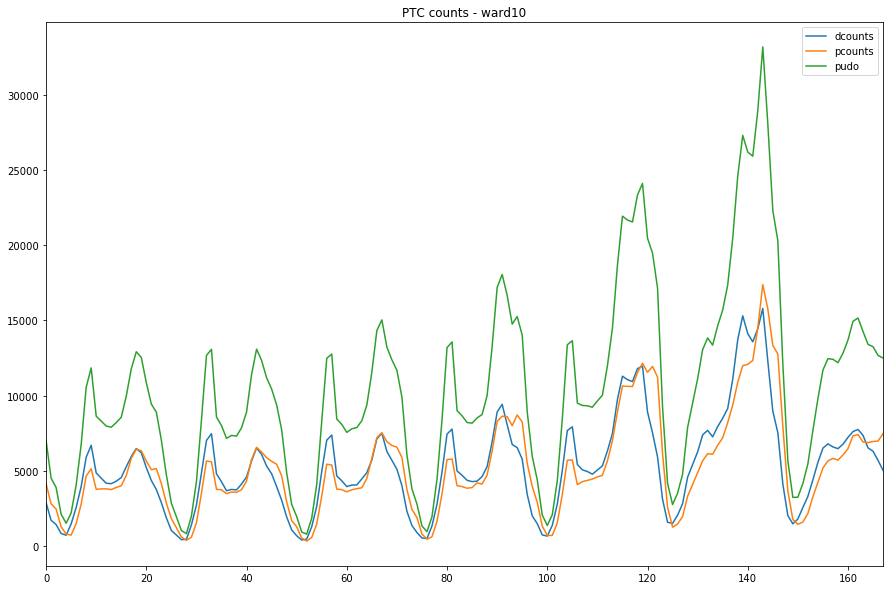

In [41]:
df_merge.plot(y=["dcounts", "pcounts", "pudo"], kind="line", use_index=True,
             title='PTC counts - ward' + repr(ward),
             figsize=(15,10))

In [42]:
df=

SyntaxError: invalid syntax (<ipython-input-42-02c2a1c0215a>, line 1)

# Create json object and write to file
Format:  
```
{
	"keys": {
		"name": "tod",
		"values": [
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167
		]
	},
	"pudo": [0.3234158,0.21998841,0.18961688,0.15678278,0.13872403, 0.48019858,0.36938352...
        ],
    "pu": [0.28592435, 0.23656836, 0.17870272, 0.1276448 , 0.11232742, 0.24337609,...
    	],
	"do": [ 0.3234158,0.21998841,0.18961688,0.15678278,0.13872403,0.25364335,0.36938352...
    ]
}
```

In [ ]:
ptcjson = {
    "keys":{
        "name":"tod", 
        "values":np.arange(df_merge.shape[0]).tolist()
    },
    "pu":pd.to_numeric(df_merge['pcounts'], downcast='signed').tolist(),
    "pudo":pd.to_numeric(df_merge['pudo'], downcast='signed').tolist(),
    "do":pd.to_numeric(df_merge['dcounts'], downcast='signed').tolist()
}

ptcjson

## Write json to file
https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/

In [ ]:
print('w' +repr(ward))

In [ ]:
df_merge.shape

In [ ]:
import json

mydir = '../../../Documents/PROJECTS/VFH/COT_PAGE/INTERIM_DATA/JSONS/'
# mydir = '/home/nangini/Documents/PROJECTS/BDITTO/VFH/DATA_STORY/DATA/JSONS/'

fname = mydir + 'ptc_counts_w' + repr(ward) + '.json'
with open(fname, 'w') as outfile:
    json.dump(ptcjson, outfile)

In [ ]:
print("200 OK")